In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [2]:
# Load and prepare data
df = pd.read_excel('Data.xlsx')
df = df.dropna().reset_index(drop=True)
df.set_index('date', inplace=True)

In [3]:
# Create lag features for relevant columns
columns_to_lag = ['gdp_growth', 'cpi_inflation', 'unemployment']
lags = 3 

for col in columns_to_lag:
    df[f'{col}_lag{lags}'] = df[col].shift(lags)

# Drop rows with missing values (created by shifting)
df = df.dropna()

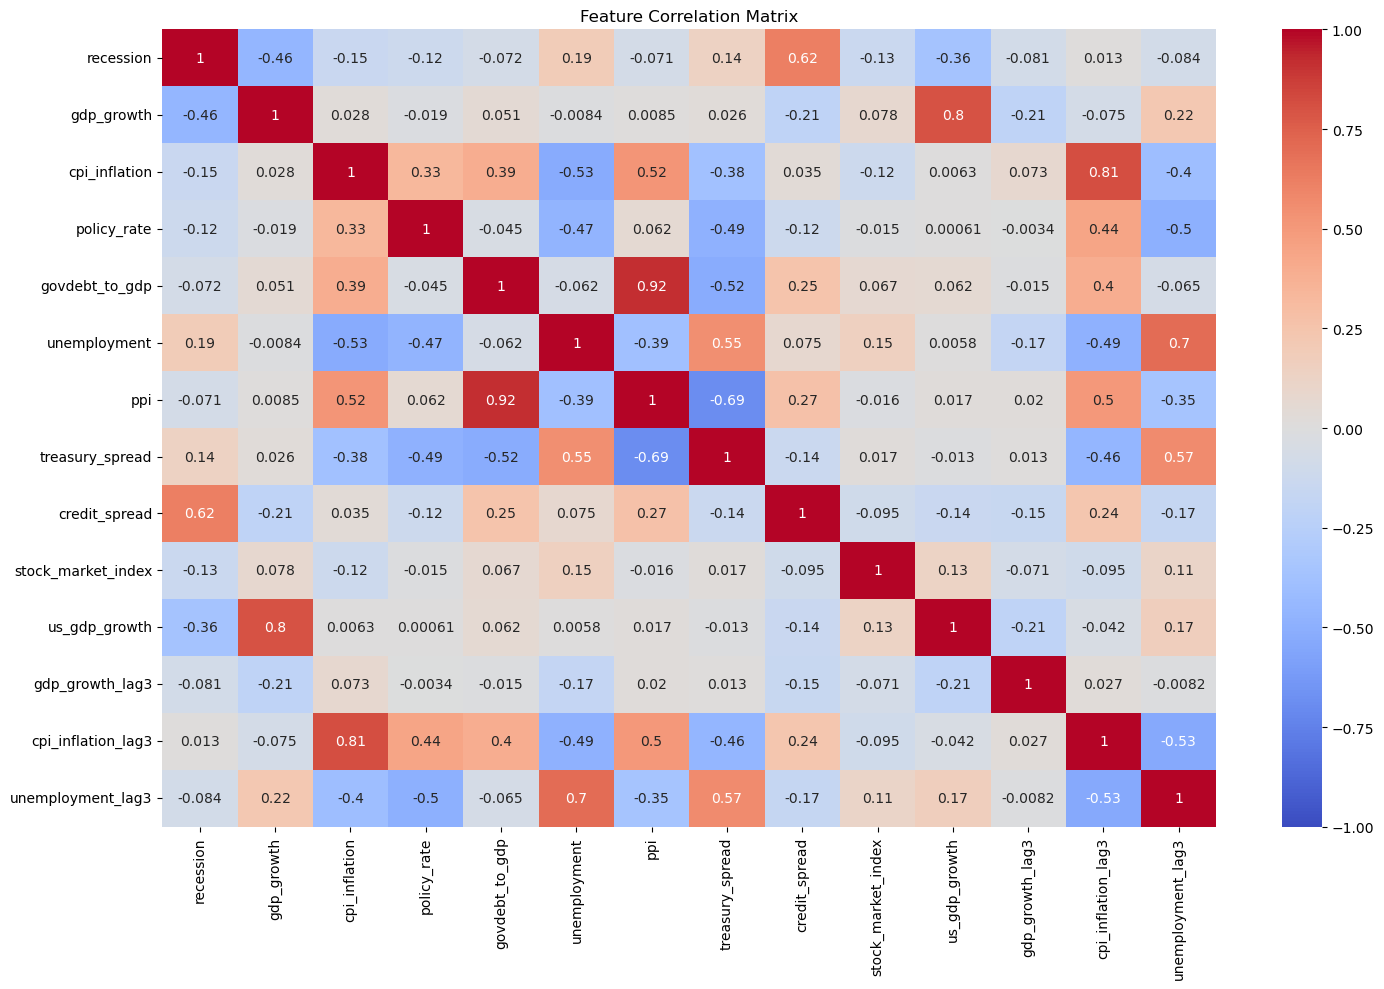

In [4]:
# Enhanced correlation analysis
plt.figure(figsize=(15, 10))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [5]:
# Adjust dataset based on correlation results
df = df.drop('govdebt_to_gdp', axis=1)

In [6]:
# Train-test split 
train, test = train_test_split(df, test_size=0.2, shuffle=False, random_state=42) 

In [7]:
# Normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train.drop('recession', axis=1))
y_train = train['recession']
X_test = scaler.transform(test.drop('recession', axis=1))
y_test = test['recession']

In [8]:
# Create evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test):
    for phase, X, y in [('Test', X_test, y_test)]:
        pred = model.predict(X)
        proba = model.predict_proba(X)[:, 1]
        
        print(f"\n{phase} Results:")
        print("=" * 50)
        print(f"Accuracy: {accuracy_score(y, pred):.2%}")
        print(f"ROC AUC: {roc_auc_score(y, proba):.2%}")
        print("\nClassification Report:")
        print(classification_report(y, pred, zero_division=0))
        print("Confusion Matrix:")
        print(confusion_matrix(y, pred))
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y, proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{phase} ROC Curve')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{phase} ROC Curve')
        plt.legend()
        plt.show()

In [9]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), 
                            use_label_encoder=False, eval_metric='logloss')
}



Logistic Regression

Test Results:
Accuracy: 98.25%
ROC AUC: 91.98%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.67      0.80         3

    accuracy                           0.98        57
   macro avg       0.99      0.83      0.90        57
weighted avg       0.98      0.98      0.98        57

Confusion Matrix:
[[54  0]
 [ 1  2]]


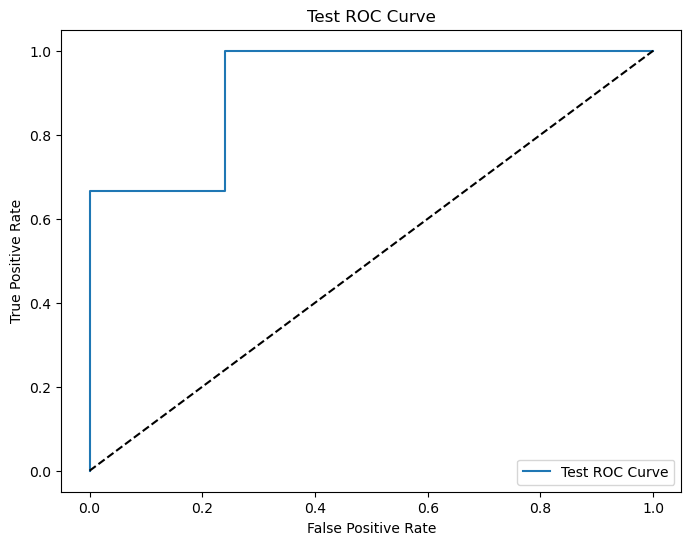


Random Forest

Test Results:
Accuracy: 94.74%
ROC AUC: 79.01%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        54
           1       0.00      0.00      0.00         3

    accuracy                           0.95        57
   macro avg       0.47      0.50      0.49        57
weighted avg       0.90      0.95      0.92        57

Confusion Matrix:
[[54  0]
 [ 3  0]]


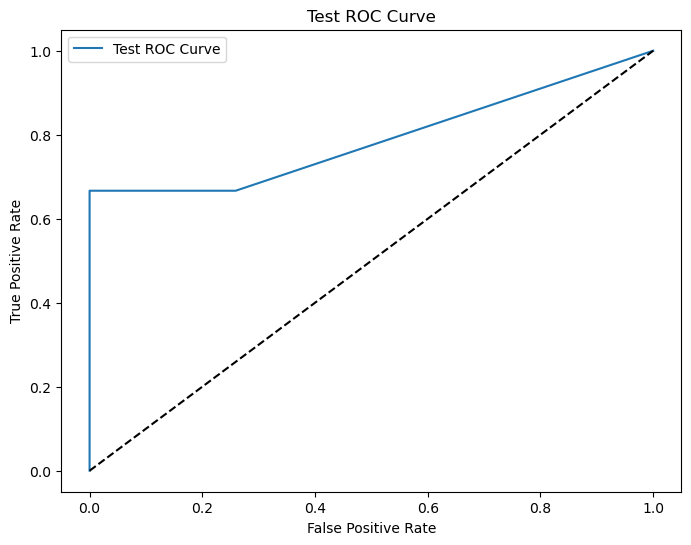


XGBoost

Test Results:
Accuracy: 96.49%
ROC AUC: 66.67%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        54
           1       1.00      0.33      0.50         3

    accuracy                           0.96        57
   macro avg       0.98      0.67      0.74        57
weighted avg       0.97      0.96      0.96        57

Confusion Matrix:
[[54  0]
 [ 2  1]]


C:\Users\Kathe\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:20:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


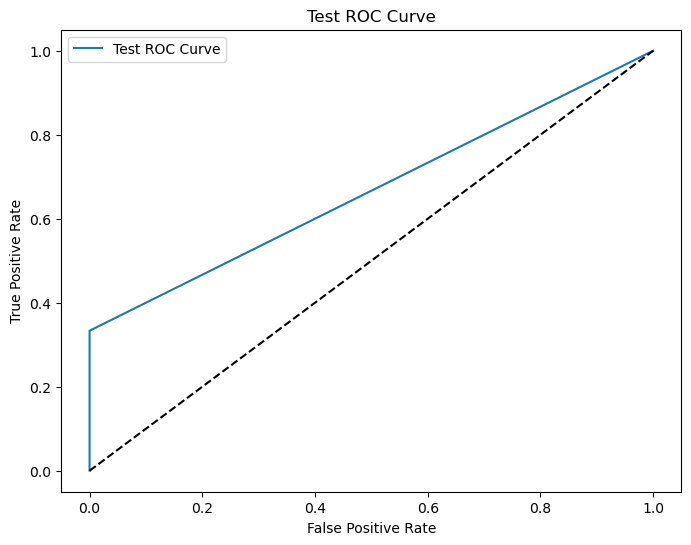

In [10]:
# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\n{'=' * 30}")
    print(f"{name}")
    print(f"{'=' * 30}")
    
    model.fit(X_train, y_train)
    evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = model

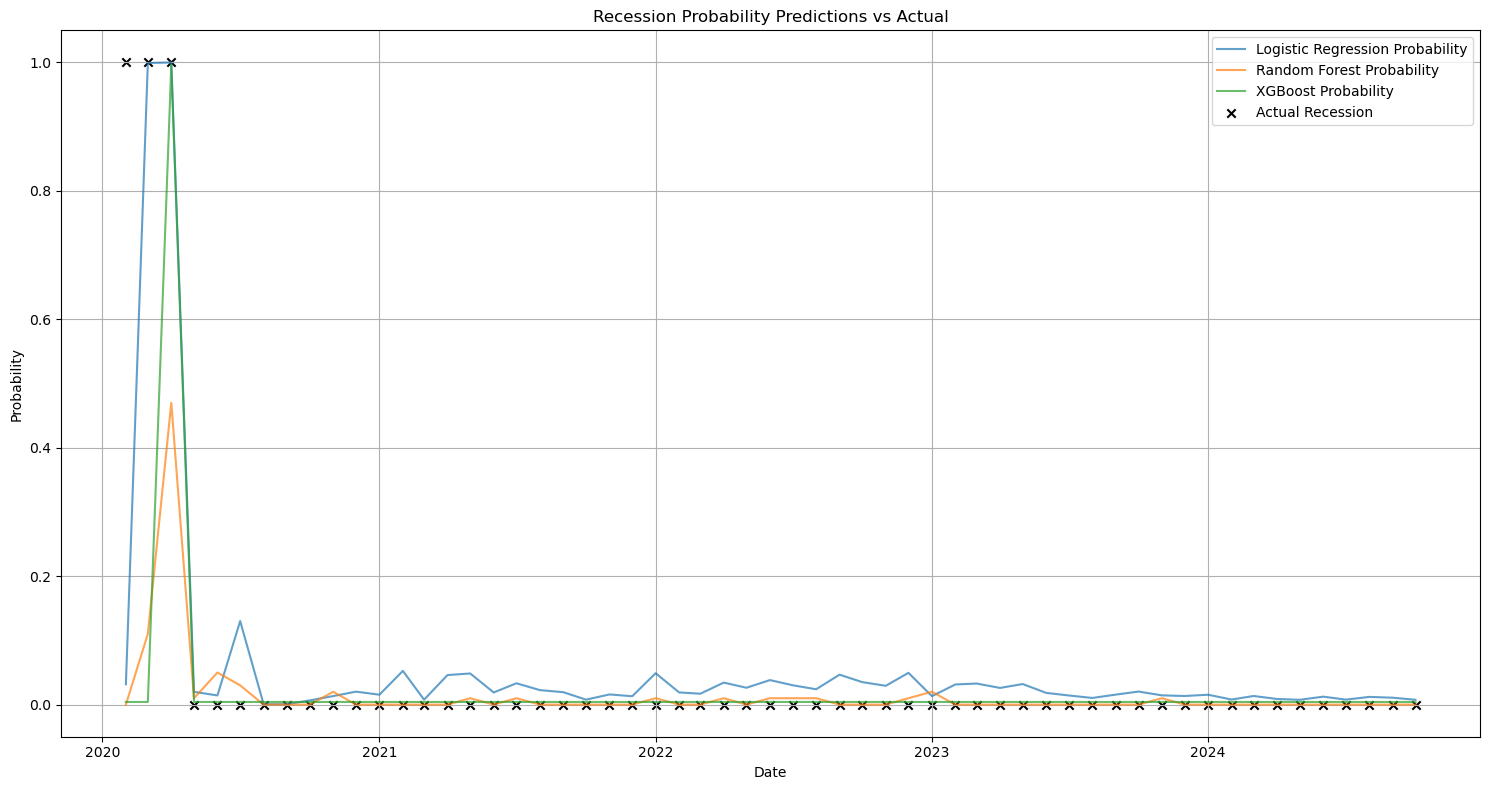

In [11]:
# Visualization of prediction probabilities
plt.figure(figsize=(15, 8))
for model_name, model in results.items():
    test_probs = model.predict_proba(X_test)[:, 1]
    plt.plot(test.index, test_probs, label=f'{model_name} Probability', alpha=0.7)

plt.scatter(test.index, test['recession'], label='Actual Recession', color='black', marker='x')
plt.title('Recession Probability Predictions vs Actual')
plt.ylabel('Probability')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest Feature Importance (Top 5 Features):
              Feature  Importance
6       credit_spread    0.338412
0          gdp_growth    0.227726
5     treasury_spread    0.141225
9     gdp_growth_lag3    0.083072
7  stock_market_index    0.050563


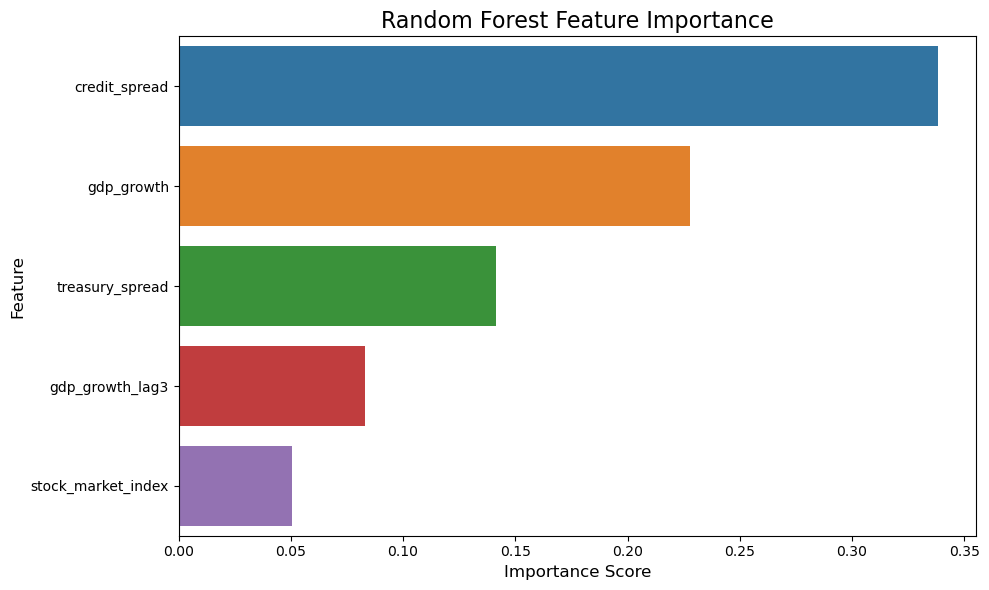

In [12]:
# Visualize feature importance for tree-base model
model = results['Random Forest']

# Get feature importances and feature names
importances = model.feature_importances_
features = train.drop('recession', axis=1).columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Print the top N most important features
top_n = 5 
print(f"\nRandom Forest Feature Importance (Top {top_n} Features):")
print(importance_df.head(top_n))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(top_n),  # Plot only top N features
    orient='h'
)
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

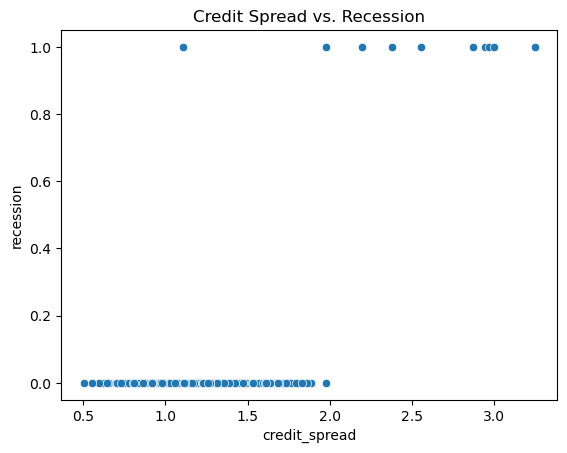

In [13]:
sns.scatterplot(x=df['credit_spread'], y=df['recession'])
plt.title('Credit Spread vs. Recession')
plt.show()